In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from random import randint

import matplotlib
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import GradientBoostingRegressor

rcParams["figure.figsize"] = 3, 3
import warnings

matplotlib.rcParams.update({'font.size': 14})

In [2]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.medians = None
        self.kitchen_square_quantile = None
        self.med_price_by_district = None
        self.med_price_by_district_median = None
        
        
    def fit(self, df, y=None):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()
        
        # Квантиль
        self.kitchen_square_quantile = df['KitchenSquare'].quantile(.975)
        
        # Target
        copy_df = df.copy()
        if y is not None:
            copy_df['New'] = y.values
            self.med_price_by_district = copy_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'New':'median'}).rename(columns={'New':'MedPriceByDistrict'})
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
    
            
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Замена буквенных значений A и B на 0 и 1
        df.loc[df['Shops_2'] == 'A', 'Shops_2'] = 0
        df.loc[df['Shops_2'] == 'B', 'Shops_2'] = 1
        df.loc[df['Ecology_2'] == 'A', 'Ecology_2'] = 0
        df.loc[df['Ecology_2'] == 'B', 'Ecology_2'] = 1
        df.loc[df['Ecology_3'] == 'A', 'Ecology_3'] = 0
        df.loc[df['Ecology_3'] == 'B', 'Ecology_3'] = 1
        # Перевод типа object в int
        df['Shops_2'] = df['Shops_2'].astype(int)
        df['Ecology_2'] = df['Ecology_2'].astype(int)
        df['Ecology_3'] = df['Ecology_3'].astype(int)
        
        
        # 2. Выбросы
        # House_Year !
        df['HY_outlier'] = 0
        df.loc[df['HouseYear'] > datetime.now().year, 'HY_outlier'] = 1
        df.loc[df['HouseYear'] > datetime.now().year, 'HouseYear'] = self.medians['HouseYear']
        
        # Rooms !
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = 3 #self.medians['Rooms']
        
        # Square !
        df['Square_outlier'] = 0
        df.loc[(df['Square'] < 16) | (df['Square'] > 300), 'Square_outlier'] = 1
        df.loc[(df['Square_outlier'] == 1), 'Square'] = self.medians['Square']
        
        # KitchenSquare !
        df['KitchenSquare_outlier'] = 0
        df.loc[(df['KitchenSquare'] < 5) | (df['KitchenSquare'] > self.kitchen_square_quantile), 'KitchenSquare_outlier'] = 1
        df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        df.loc[df['KitchenSquare'] > self.kitchen_square_quantile, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor !
        df['HF_outlier'] = 0
        df.loc[(df['Floor'] > df['HouseFloor']) | (df['HouseFloor'] == 0) | (df['HouseFloor'] > 90), 'HF_outlier'] = 1
        
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']
        df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] > 90), 'HouseFloor'] = self.medians['HouseFloor']
        
        
        # 3. Пропуски
        # HealthCare_1
        df['Healthcare_1_outlier'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_outlier'] = 1
        
        hc_notnan = df[['DistrictId', 'Social_3', 'Healthcare_1']].loc[~train_data['Healthcare_1'].isna()]
        hc_notnan = hc_notnan.groupby(['DistrictId', 'Social_3'], as_index=False).agg({'Healthcare_1':'mean'}).rename(columns={'Healthcare_1':'Healthcare_mean'})
        df = df.merge(hc_notnan, on=['DistrictId', 'Social_3'], how='left')
        
        df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_mean'])
        df['Healthcare_1'] = df['Healthcare_1'].fillna(self.medians['Healthcare_1'])
        df.drop('Healthcare_mean', axis=1, inplace=True)
        
        # LifeSquare !
        df['LifeSquare_outlier'] = 0
        df.loc[(df['Square'] < df['LifeSquare']) | (df['LifeSquare'].isna()), 'LifeSquare_outlier'] = 1
        df.loc[df['LifeSquare_outlier'] == 1, 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 5
        
        df.fillna(self.medians, inplace=True)
        
        # 4. Новые признаки
        # Отношение social1 к social_2 для понижения размерности признаков
        df['S1/S2'] = df['Social_1'] / df['Social_2']
        
        # DistrictId to DistrictId_cat
        bins = [0, 50, 100, 150, 200, df['DistrictId'].max()]
        df['DistrictId_cat'] = pd.cut(df['DistrictId'], bins=bins, labels=False)
        df['DistrictId_cat'].fillna(-1, inplace=True)
        
        # HouseYear to HouseYear_cat
        bins = [1910, 1930, 1950, 1970, 1990, 2010, datetime.now().year]
        df['HouseYear_cat'] = pd.cut(df['HouseYear'], bins=bins, labels=False)
        df['HouseYear_cat'].fillna(-1, inplace=True)
        
        # 5. Target
        
        if self.med_price_by_district is not None:
            df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            df.fillna(self.med_price_by_district_median, inplace=True)
            df['MedPriceByDistrict'] = df['MedPriceByDistrict'] / df['Rooms']
            
        return df


In [3]:
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'prepared_train1.csv'

TEST_PATH = 'test.csv'
PREPARED_TEST_PATH = 'prepared_test1.csv'

In [4]:
train_data = pd.read_csv(DATASET_PATH)
train_data.shape

(10000, 20)

**Целевая переменная**

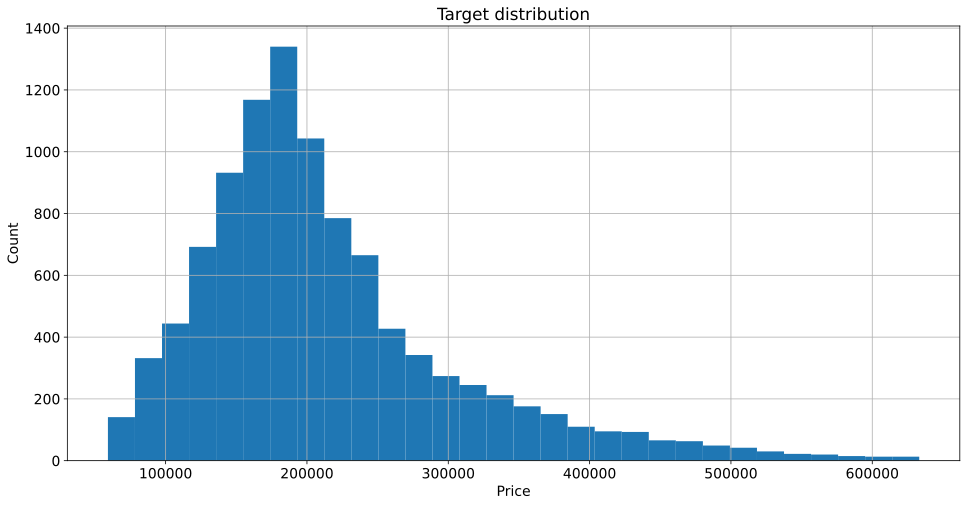

In [5]:
plt.figure(figsize = (16, 8))

train_data['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [6]:
test_data = pd.read_csv(TEST_PATH)
test_data.shape

(5000, 19)

In [7]:
pipe = DataPipeline()
pipe.fit(train_data.drop(columns='Price'), train_data['Price'])
train_data = pipe.transform(train_data)

train_data.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [8]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,KitchenSquare_outlier,HF_outlier,Healthcare_1_outlier,LifeSquare_outlier,S1/S2,DistrictId_cat,HouseYear_cat,MedPriceByDistrict
count,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,8383.40770,50.400800,1.88800,56.228457,38.351534,6.878700,7.70040,12.931500,1984.863800,0.118858,...,0.001200,0.00160,0.341100,0.182800,0.479800,0.258700,0.004436,0.586100,3.28040,122518.169615
std,4859.01902,43.587592,0.81174,19.058793,18.515965,2.129939,5.30406,6.241322,18.409979,0.119025,...,0.034622,0.03997,0.474103,0.386522,0.499617,0.437942,0.001126,0.826834,0.98543,40319.632422
min,0.00000,0.000000,1.00000,16.117154,0.370619,5.000000,0.00000,1.000000,1910.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.00000,20585.693968
25%,4169.50000,20.000000,1.00000,41.800063,24.640013,5.000000,4.00000,9.000000,1974.000000,0.017647,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.003788,0.000000,3.00000,93627.360181
50%,8394.50000,36.000000,2.00000,52.513310,33.947524,6.000000,7.00000,13.000000,1977.000000,0.075424,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.004413,0.000000,3.00000,115809.891073
75%,12592.50000,75.000000,2.00000,65.889736,47.532487,8.000000,11.00000,17.000000,2001.000000,0.195781,...,0.000000,0.00000,1.000000,0.000000,1.000000,1.000000,0.005019,1.000000,4.00000,146735.671740
max,16798.00000,209.000000,5.00000,275.645284,233.949309,13.000000,42.00000,48.000000,2020.000000,0.521867,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.007937,4.000000,5.00000,397528.736061


In [9]:
train_data.isnull().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HY_outlier               0
Rooms_outlier            0
Square_outlier           0
KitchenSquare_outlier    0
HF_outlier               0
Healthcare_1_outlier     0
LifeSquare_outlier       0
S1/S2                    0
DistrictId_cat           0
HouseYear_cat            0
MedPriceByDistrict       0
dtype: int64

In [10]:
test_data = pipe.transform(test_data)

test_data.to_csv(PREPARED_TEST_PATH, index=False, encoding='utf-8')

In [11]:
test_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,KitchenSquare_outlier,HF_outlier,Healthcare_1_outlier,LifeSquare_outlier,S1/S2,DistrictId_cat,HouseYear_cat,MedPriceByDistrict
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,...,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.906400,56.543749,38.393119,6.875200,7.838000,12.92440,1984.392600,0.119874,...,0.00100,0.002000,0.328600,0.177000,0.475400,0.255800,0.004440,0.605200,3.257800,121948.495278
std,4832.674037,44.179466,0.806579,18.955344,17.997569,2.135167,5.454989,6.35128,18.573149,0.120070,...,0.03161,0.044681,0.469751,0.381707,0.499444,0.436354,0.001129,0.838018,1.002168,40693.744805
min,1.000000,0.000000,1.000000,16.319015,0.333490,5.000000,0.000000,1.00000,1908.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,41229.769143
25%,4221.750000,21.000000,1.000000,41.951045,24.845544,5.000000,4.000000,9.00000,1973.000000,0.019509,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003788,0.000000,3.000000,91910.218540
50%,8320.500000,37.000000,2.000000,52.921340,34.310735,6.000000,7.000000,13.00000,1977.000000,0.072158,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004413,0.000000,3.000000,113590.729081
75%,12598.250000,77.000000,2.000000,66.285129,47.785081,8.000000,11.000000,17.00000,2000.000000,0.195781,...,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.005031,1.000000,4.000000,146735.671740
max,16795.000000,212.000000,5.000000,223.453689,158.729035,13.000000,46.000000,48.00000,2020.000000,0.521867,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.007937,4.000000,5.000000,381937.404161


In [12]:
test_data.isnull().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
HY_outlier               0
Rooms_outlier            0
Square_outlier           0
KitchenSquare_outlier    0
HF_outlier               0
Healthcare_1_outlier     0
LifeSquare_outlier       0
S1/S2                    0
DistrictId_cat           0
HouseYear_cat            0
MedPriceByDistrict       0
dtype: int64

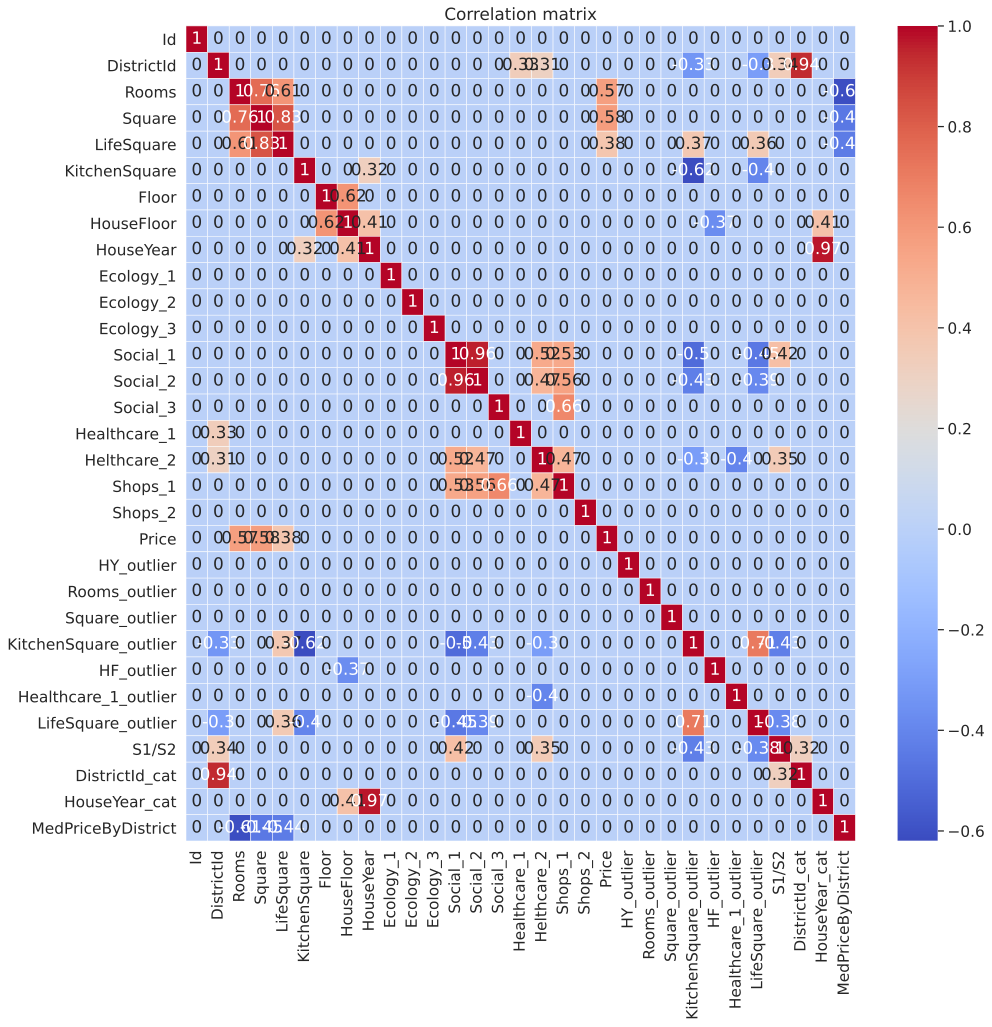

In [44]:
plt.figure(figsize = (15,15))

sns.set(font_scale=1.4)

corr_matrix = train_data.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Расчет значений**

In [14]:
data = pd.read_csv(PREPARED_DATASET_PATH)
data.drop('Id', axis=1, inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DistrictId             10000 non-null  int64  
 1   Rooms                  10000 non-null  float64
 2   Square                 10000 non-null  float64
 3   LifeSquare             10000 non-null  float64
 4   KitchenSquare          10000 non-null  float64
 5   Floor                  10000 non-null  float64
 6   HouseFloor             10000 non-null  float64
 7   HouseYear              10000 non-null  float64
 8   Ecology_1              10000 non-null  float64
 9   Ecology_2              10000 non-null  int64  
 10  Ecology_3              10000 non-null  int64  
 11  Social_1               10000 non-null  int64  
 12  Social_2               10000 non-null  int64  
 13  Social_3               10000 non-null  int64  
 14  Healthcare_1           10000 non-null  float64
 15  Hel

**Признаки**

In [16]:
data.keys()

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'HY_outlier', 'Rooms_outlier',
       'Square_outlier', 'KitchenSquare_outlier', 'HF_outlier',
       'Healthcare_1_outlier', 'LifeSquare_outlier', 'S1/S2', 'DistrictId_cat',
       'HouseYear_cat', 'MedPriceByDistrict'],
      dtype='object')

**С использованием признака, созданного на основе таргета, получается значение r2 выше, чем без него. Но на kaggle резуьтат был не очень хорошим. Поэтому для итоговой модели я ее не использую**

In [17]:
feature_names = [
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
                 'Floor',
                 'HouseFloor', 
                 'Ecology_1', 
                 'Ecology_2', 
                 'Ecology_3',
                 'Social_3',
                 'Helthcare_2',
                 'Shops_1', 
                 'Shops_2', 
                'KitchenSquare_outlier',
                'HF_outlier',
                'LifeSquare_outlier',
                'S1/S2',
                'DistrictId_cat',
                'HouseYear_cat',
#                 'MedPriceByDistrict'
                            ]

target_name = 'Price'

In [18]:
X = data[feature_names]
X.head(1)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_outlier,HF_outlier,LifeSquare_outlier,S1/S2,DistrictId_cat,HouseYear_cat
0,2.0,47.981561,29.442751,6.0,7.0,9.0,0.08904,1,1,5,0,11,1,0,0,0,0.004137,0.0,2.0


In [19]:
y = pd.DataFrame(data[target_name], columns=['Price'])
y.head(1)

,Price
0,184966.93073


**Разбиение на train и valid**

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

**Построение модели.
Здесь используем GradientBoostingRegressor**

In [21]:
gbr = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=5,
                                        random_state=42,  
                                        n_estimators=100
                               )

In [22]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=5,
                          random_state=42)

In [23]:
y_pred = gbr.predict(X_valid)

**Расчет r2**

In [24]:
r2(y_valid, y_pred)

0.724062395312199

**Вес признаков**

In [25]:
model_features = gbr.feature_importances_

In [26]:
sum(model_features)

1.0

In [27]:
model_features = pd.DataFrame({'feature_weight': model_features},
                             feature_names)
model_features.sort_values(by='feature_weight', ascending=False)

,feature_weight
Square,0.418269
Social_3,0.145087
S1/S2,0.101484
Rooms,0.069822
Ecology_1,0.051988
Shops_1,0.050261
LifeSquare,0.030921
KitchenSquare,0.025692
HouseFloor,0.024407
Helthcare_2,0.020887


**Кросс-валидация**

In [28]:
cv_score = cross_val_score(gbr, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=11))
cv_score

array([0.75177288, 0.71637179, 0.72835426, 0.75153074, 0.73687019])

In [29]:
cv_score.mean()

0.7369799719085627

**Расчет параметров с GridSearchCV**

In [30]:
# params = {'n_estimators':[100, 200, 400, 500, 700], 
#           'max_depth':[3, 5, 7, 9]}

# gs = GridSearchCV(gbr, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [31]:
# res = pd.DataFrame(gs.cv_results_)
# res.head(1)

In [32]:
# gs.best_params_
# {'max_depth': 5, 'n_estimators': 100}

In [33]:
# gs.best_score_

**Расчет значений для test**

In [34]:
X_test = pd.read_csv(PREPARED_TEST_PATH)
y_test = pd.DataFrame(X_test['Id'])
X_test = X_test[feature_names] #.drop('Id', axis=1, inplace=True)

In [35]:
X_test.head(1)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Ecology_2,Ecology_3,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_outlier,HF_outlier,LifeSquare_outlier,S1/S2,DistrictId_cat,HouseYear_cat
0,2.0,49.882643,33.432782,6.0,6.0,14.0,0.310199,1,1,1,0,0,1,0,0,0,0.004003,1.0,3.0


In [36]:
y_test.head(1)

,Id
0,725


In [37]:
y_pred_test = gbr.predict(X_test)

In [38]:
y_test['Price'] = y_pred_test

In [39]:
y_test.to_csv('test_submission.csv', index=False, encoding='utf-8')

In [40]:
check_test = pd.DataFrame({
    "y_valid": y_valid['Price'],
    "y_pred": y_pred,
})

check_test.head(4)

,y_valid,y_pred
6252,181530.459031,187715.463355
4684,260456.004692,328018.753883
1731,219945.304640,219043.591138
4742,66883.280318,67641.706823


In [41]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.906
RMSE:	28525.653
MSE:	813712891.41


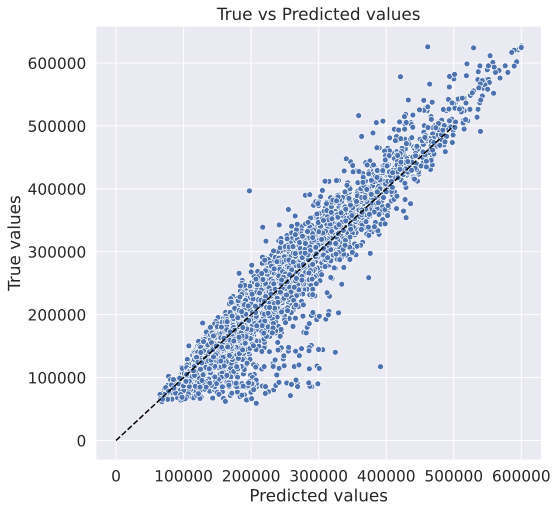

In [42]:
y_pred_train = gbr.predict(X_train)
y_pred_train = np.clip(y_pred_train, a_min=10000, a_max=600000)
#
evaluate_preds(y_train['Price'], y_pred_train)

R2:	0.724
RMSE:	48719.069
MSE:	2373547670.938


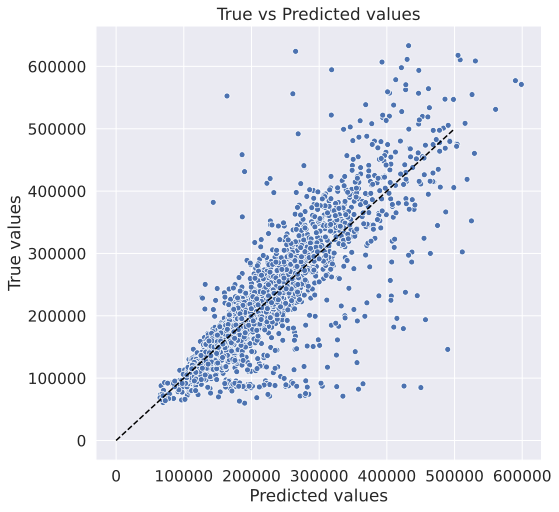

In [43]:
y_pred = np.clip(y_pred, a_min=10000, a_max=600000)
#
evaluate_preds(y_valid['Price'], y_pred)